In [1]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scipy.stats import norm


plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

In [3]:
# file_list = ["10051505", "10051538", "10051611", "10051645", "10051718", "10051751", "10051825", "10051858", "10051931", "10052005"]
# prefix = "/home/ap2339/newburgh-group-2/new_gps/ground_tests/"

# df = pd.read_csv(prefix+file_list[0],sep=",",header=1)
# df = df.assign(UTC = pd.to_datetime(df.UTC))

# for fname in file_list[1:]:
#     new_df = pd.read_csv(prefix+fname, sep=',', header=1)
#     new_df = new_df.assign(UTC = pd.to_datetime(new_df.UTC))
#     df = pd.concat([df, new_df], axis=0, join='inner')

# df.reset_index(drop=True, inplace=True)
# fig = plt.figure()
# #plt.plot(df.carrierSoln)
# #plt.plot(df.carrierSoln[24600:26100])
# #plt.plot(df.carrierSoln[85900:87900])

# plt.plot(df.HMSL[24600:26100])
# # plt.plot(df.HMSL[85900:87900])

# point_df = df[24600:26100]
# print(26100-24600)


df = pd.read_csv(prefix+"10061717", sep=",", header=1)
df = df.assign(UTC = pd.to_datetime(df.UTC))

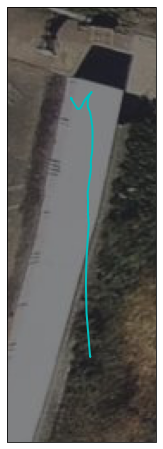

In [6]:
MAPBOX_KEY = "pk.eyJ1IjoiYW5uaWVwb2xpc2giLCJhIjoiY2p5b3BwdXl3MTdhdzNjdDRjbGw5MWJ6ciJ9.01NjskBuc2SQcm5QjbyLwA"
MAPBOX_STYLE = "cjypy1k7x0ru71cjva7cs5iwz"
MAPBOX_USERNAME = "anniepolish"
PLOT_BG = cimgt.MapboxStyleTiles(MAPBOX_KEY, MAPBOX_USERNAME, MAPBOX_STYLE)
BORDER = 0.00005

fig = plt.figure()

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# set the extents of the plot to be a box around the data
ax.set_extent([min(df.Lon)-BORDER, max(df.Lon)+BORDER, min(df.Lat)-BORDER, max(df.Lat)+BORDER], crs=ccrs.Geodetic())

# use cartopy to add a satellite map to the background
ax.add_image(PLOT_BG, 20)

# plot the data, transformed into the coordinate system of our plot
plt.plot(df.Lon, df.Lat, 'c', linewidth=2, transform=ccrs.Geodetic(), label="GPS")

# label and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



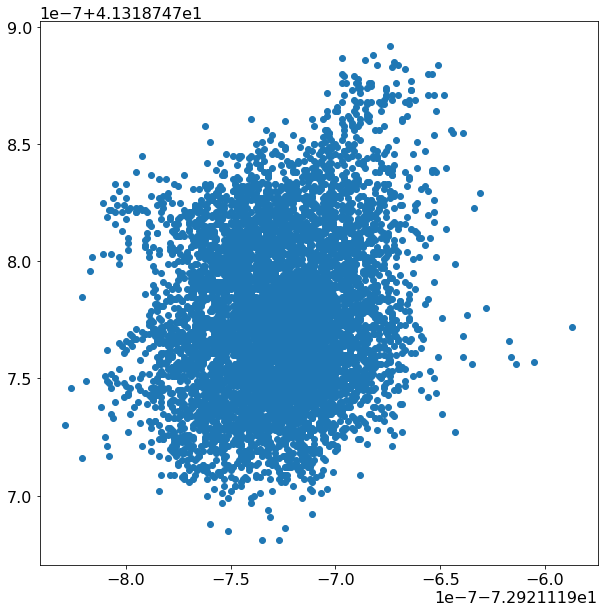

In [13]:
fig = plt.figure(figsize=(10,10))
#plt.scatter(df.Lon, df.Lat)
#plt.scatter(df[24600:26100].Lon, df[24600:26100].Lat)
#plt.scatter(df[85900:87900].Lon, df[85900:87900].Lat)
cut = 200
plt.scatter(df.Lon[cut:], df.Lat[cut:])
plt.show()

1436.999301


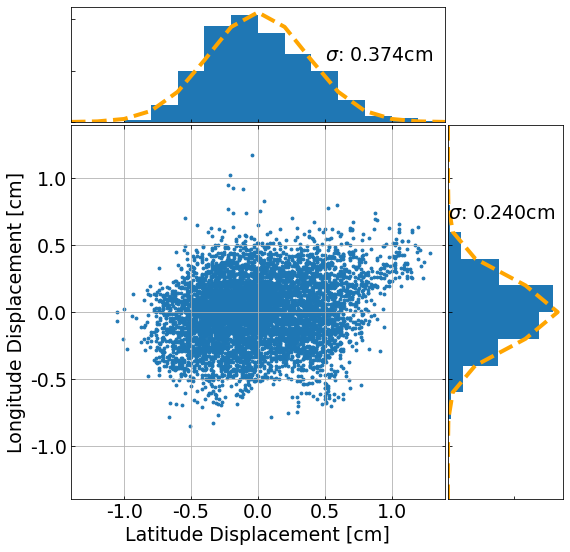

In [44]:
plt.rcParams.update({'font.size': 19})

# lat_arr = df[24600:26100].Lat.values
# lon_arr = df[24600:26100].Lon.values

# lat_arr = df[85900:87900].Lat.values
# lon_arr = df[85900:87900].Lon.values

cut = 200

lat_arr = df.Lat.values[cut:]
lon_arr = df.Lon.values[cut:]

print((df.UTC.values[-1]-df.UTC.values[cut])/np.timedelta64(1, 's'))

# convert each of the latitude and longitude arrays into a displacement from mean, in meters
center_lat = np.mean(lat_arr)
center_lon = np.mean(lon_arr)
lat_disp, lon_disp = [], []
for lat in lat_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (lat, center_lon)).m*100.
    if (lat < center_lat): disp = -1.*disp
    lat_disp.append(disp)
for lon in lon_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (center_lat, lon)).m*100.
    if (lon < center_lon): disp = -1.*disp
    lon_disp.append(disp)    

x = lat_disp
y = lon_disp

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
label_gap = 0.02


rect_scatter = [label_gap+left, bottom, width, height]
rect_histx = [label_gap+left, bottom + height + spacing, width, 0.2]
rect_histy = [label_gap+left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelleft=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False)

# the scatter plot:
ax_scatter.scatter(x, y, s=8)
ax_scatter.grid()


# now determine nice limits by hand:
binwidth = 0.2
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
#ax_scatter.yaxis.set_ticks([-0.5,0,0.5])
#ax_scatter.grid()


bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins, density=True)
ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

# make and add gaussian fits
lat_mu, lat_sigma = norm.fit(lat_disp)
lon_mu, lon_sigma = norm.fit(lon_disp)
ax_histx.plot(bins, norm.pdf(bins, lat_mu, lat_sigma), '--', color='orange', linewidth=4)
ax_histy.plot(norm.pdf(bins, lon_mu, lon_sigma), bins, '--', color='orange', linewidth=4)
ax_histx.text(0.5, 0.6, "$\sigma$: %.3fcm"%lat_sigma)
ax_histy.text(0., 0.7, "$\sigma$: %.3fcm"%lon_sigma)

# LABELS LABELS LABELS
ax_scatter.set_xlabel("Latitude Displacement [cm]")
ax_scatter.set_ylabel("Longitude Displacement [cm]")

plt.savefig("stationary_point_2021-10-6.png")
plt.show()

